In [1]:
#Importing libraries
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import numpy as np
import pandas as pd
from numpy import asarray
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import datetime
from statsmodels.tsa.tsatools import lagmat
from statsmodels.tsa.arima.model import ARIMA

# Data Import and Cleaning

In [2]:
df = pd.read_excel("/Users/surajkwork/Documents/Thesis/thesis/df.xlsx")

The date variable is not in datetime format so it has to be converted.

In [3]:
df['date']= pd.to_datetime(df['date'])
df.index = df['date']
df.sort_index(inplace=True)

Extracting one cluster from the dataset for analysis.

In [4]:
TS1 = df[(df['Plz'] == "['25', '24']")]

And from this cluster, extracting one category for analysis.

In [5]:
TS1_A2 = TS1[TS1['full'] == 'A2 -  geschreddert']
TS1_A1A2 = TS1[TS1['full'] == 'A1 & A2 -  geschreddert']
TS1_A2A3 = TS1[TS1['full'] == 'A2 & A3 -  geschreddert']

In [9]:
nobs = 6
df_train, df_test = TS1_A1A2[0:-nobs], TS1_A1A2[-nobs:]

## Decision Tree

In [6]:
from sklearn.tree import DecisionTreeRegressor
from skforecast.ForecasterAutoreg import ForecasterAutoreg

We can use Decision Trees to predict in a few different ways.
1. Use just the previous observation to predict the next time step (this may not be too useful)
2. Use a sequence of past observations to predict the next time step (this sequence can corresponds to our lag of 4) 
3. Use a sequence of past observations to predict a sequence of future time steps (this can correspond to a "static forecast", while still using the lag of 4 as the sequence)

## Static Forecast

First, we can try 3. Using a lag of 4, training the model only on the training dataset and predicting for the 6 time steps.

In [7]:
# Define the forecaster
forecaster = ForecasterAutoreg(
    # Add the sklearn regressor and lags
    regressor = DecisionTreeRegressor(random_state = 123),
    lags = 4
)

In [10]:
y_train = df_train['wPreis']

# Check if y_train is a pandas Series
# print(isinstance(y_train, pd.Series))  # Should print True

In [11]:
# Now you can pass y_train to forecaster.fit()
forecaster.fit(y=y_train)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/skforecast/utils/utils.py:805: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/skforecast/utils/utils.py:805: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(


In [12]:
# Predict the test period
predicted_test = forecaster.predict(steps = len(df_test))

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/skforecast/utils/utils.py:867: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(


In [15]:
predicted_test

4   -5.714546
5   -0.307413
6   -5.714546
7   -0.307413
8    7.293524
9    8.006889
Name: pred, dtype: float64

In [13]:
def forecast_accuracy(forecast, actual):
      me = np.mean(forecast - actual)             # ME
      rmse = np.mean((forecast - actual)**2)**.5  # RMSE
      # Direction accuracy
      forecast_diff = np.diff(forecast)
      actual_diff = np.diff(actual)
      direction_accuracy = np.mean(np.sign(forecast_diff) == np.sign(actual_diff))
    
      return {'me': me, 'rmse': rmse, 'direction_accuracy': direction_accuracy}


In [14]:
predicted_test.index = df_test.index


In [16]:
def adjust(val, length= 6): return str(val).ljust(length) # length
print('Decision Tree Static Forecast Accuracy of: wPreis')
accuracy_prod = forecast_accuracy(predicted_test, df_test['wPreis'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

Decision Tree Static Forecast Accuracy of: wPreis
me     :  -4.7106
rmse   :  7.9432
direction_accuracy :  0.8


## Walk-forward validation

Now we try the Walk-forward validation

In [17]:
history = y_train 

In [18]:
predictions = list()
for t in range(len(df_test)): # 6 times reiterate
    forecaster.fit(y=history)
    output = forecaster.predict(steps = 1)
    predictions.append(output)
    obs = df_test['wPreis'][t]
    obs_series = pd.Series(obs)
    history = history.append(obs_series, ignore_index=True)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/skforecast/utils/utils.py:805: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/skforecast/utils/utils.py:805: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/skforecast/utils/utils.py:867: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(


In [21]:
predictions 

[4   -5.714546
 Name: pred, dtype: float64,
 149    7.458214
 Name: pred, dtype: float64,
 150    7.83275
 Name: pred, dtype: float64,
 151    3.525113
 Name: pred, dtype: float64,
 152    3.896402
 Name: pred, dtype: float64,
 153    3.896402
 Name: pred, dtype: float64]

In [19]:
predictions_series = pd.concat(predictions, ignore_index=True)
predictions_series.index = df_test.index
predictions_series

date
2023-07-31   -5.714546
2023-08-07    7.458214
2023-08-14    7.832750
2023-08-21    3.525113
2023-08-28    3.896402
2023-09-04    3.896402
Name: pred, dtype: float64

In [20]:
def adjust(val, length= 6): return str(val).ljust(length) # length
print('Decision Tree Walk-forward Forecast Accuracy of: wPreis')
accuracy_prod = forecast_accuracy(predictions_series, df_test['wPreis'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

Decision Tree Walk-forward Forecast Accuracy of: wPreis
me     :  -1.771
rmse   :  5.8298
direction_accuracy :  0.4


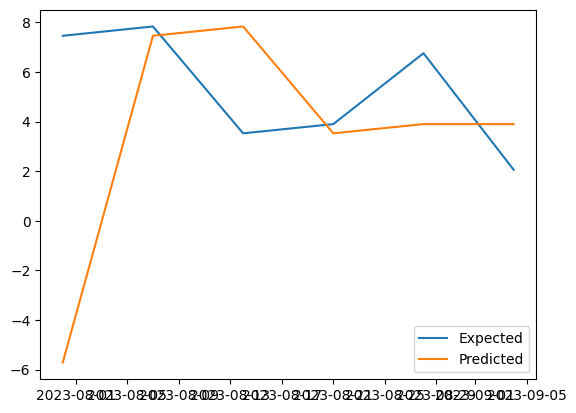

In [21]:
# plot expected vs preducted
plt.plot(df_test['wPreis'], label='Expected')
plt.plot(predictions_series, label='Predicted')
plt.legend()
plt.show()

This was walk-forward validation